In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE
import ast

def tune_hyperparameters(X_train, y_train):
    """Perform hyperparameter tuning using GridSearchCV."""
    # Define the pipeline for preprocessing and model training
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),  # Vectorizer for text data
        ('nb', MultinomialNB())       # Naive Bayes classifier
    ])

    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'tfidf__max_features': [2000, 3000, 5000, 10000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'tfidf__min_df': [1, 2, 3],
        'tfidf__stop_words': [None, stopwords.words('english')],
        'nb__alpha': [1.0, 0.5, 0.1, 0.01]
    }

    # Perform grid search with stratified cross-validation
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipeline, param_grid, cv=stratified_cv, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Return the best parameters and the best model from grid search
    return grid_search.best_params_, grid_search.best_estimator_

def preprocess_data(train_df, test_df):
    """Preprocess training and testing datasets."""
    # Drop missing values
    train_data = train_df.dropna()
    test_data = test_df.dropna()
    
    # Map labels to 0 and 1
    train_data['label'] = train_data['label'].map({'Not Hallucination': 0, 'Hallucination': 1})
    test_data['label'] = test_data['label'].map({'Not Hallucination': 0, 'Hallucination': 1})

    # Convert string representations of lists to actual lists
    train_data['hyp_lemmas'] = train_data['hyp_lemmas'].apply(ast.literal_eval)
    train_data['tgt_src_lemmas'] = train_data['tgt_src_lemmas'].apply(ast.literal_eval)
    test_data['hyp_lemmas'] = test_data['hyp_lemmas'].apply(ast.literal_eval)
    test_data['tgt_src_lemmas'] = test_data['tgt_src_lemmas'].apply(ast.literal_eval)

    # Combine `hyp_lemmas` and `res_lemmas` into a single text feature
    train_data['combined_text'] = train_data['hyp_lemmas'].apply(lambda x: " ".join(x)) + " " + train_data['tgt_src_lemmas'].apply(lambda x: " ".join(x))
    test_data['combined_text'] = test_data['hyp_lemmas'].apply(lambda x: " ".join(x)) + " " + test_data['tgt_src_lemmas'].apply(lambda x: " ".join(x))

    # Extract features (text) and labels
    X_train_full = train_data['combined_text']
    y_train_full = train_data['label']

    X_test = test_data['combined_text']
    y_test = test_data['label']

    return X_train_full, y_train_full, X_test, y_test, test_data

def train_and_evaluate(X_train_full, y_train_full, X_test, y_test, test_data):
    """Train and evaluate the model with hyperparameter tuning."""
    # Split training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
    )

    # Vectorize text data using TF-IDF
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, stop_words=None)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_val_vec = vectorizer.transform(X_val)
    X_test_vec = vectorizer.transform(X_test)

    # Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train)

    # Perform hyperparameter tuning to find the best model
    best_params, best_model = tune_hyperparameters(X_train, y_train)

    # Evaluate the best model on the validation set
    y_val_pred = best_model.predict(X_val)
    print("Validation Classification Report:")
    print(classification_report(y_val, y_val_pred))

    # Retrain the best model on the full training data (including validation)
    best_model.fit(X_train_full, y_train_full)

    # Evaluate the retrained model on the test set
    y_test_pred = best_model.predict(X_test)
    print(f"Best Parameters: {best_params}")
    print("Test Classification Report:")
    print(classification_report(y_test, y_test_pred))

    # Add predicted labels to the test data for manual inspection
    test_data['predicted_label'] = y_test_pred
    print("Test data with actual and predicted labels:")
    print(test_data[['combined_text', 'label', 'predicted_label']])

    # Save the test data with predictions to a CSV file
    test_data.to_csv("test_data_with_predictions.csv", index=False)
    print("Predictions saved to 'test_data_with_predictions.csv'.")

# Main process
if __name__ == "__main__":
    train_df = pd.read_csv('data/labeled_data/preprocessed/train_preprocessed.csv')
    test_df = pd.read_csv('data/labeled_data/preprocessed/test_preprocessed.csv')

    # Preprocess data and extract features and labels
    X_train_full, y_train_full, X_test, y_test, test_data = preprocess_data(train_df, test_df)

    # Train the model and evaluate its performance
    train_and_evaluate(X_train_full, y_train_full, X_test, y_test, test_data)

C:\Users\Admin\AppData\Local\Temp\ipykernel_22072\1261983347.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['label'] = train_data['label'].map({'Not Hallucination': 0, 'Hallucination': 1})
C:\Users\Admin\AppData\Local\Temp\ipykernel_22072\1261983347.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['hyp_lemmas'] = train_data['hyp_lemmas'].apply(ast.literal_eval)
C:\Users\Admin\AppData\Local\Temp\ipykernel_22072\1261983347.py:48: SettingWithCopyWarning: 
A value is trying to be

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.77      0.72      3022
           1       0.73      0.62      0.67      2971

    accuracy                           0.70      5993
   macro avg       0.70      0.70      0.70      5993
weighted avg       0.70      0.70      0.70      5993

Best Parameters: {'nb__alpha': 0.1, 'tfidf__max_features': 10000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}
Test Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.65      0.51       502
           1       0.75      0.54      0.63       998

    accuracy                           0.57      1500
   macro avg       0.58      0.59      0.57      1500
weighted avg       0.64      0.57      0.59      1500

Test data with actual and predicted labels:
                                  

In [4]:
# Reload the dataset
data = pd.read_csv("test_data_with_predictions.csv")

# Count hallucinations and non-hallucinations in the label and predicted columns
label_counts = data['label'].value_counts()
predicted_counts = data['predicted_label'].value_counts()

# Prepare the results as a DataFrame for clarity
results = pd.DataFrame({
    "Type": [1, 2],
    "Count in Label": [label_counts.get(1, 0), label_counts.get(0, 0)],
    "Count in Predicted": [predicted_counts.get(1, 0), predicted_counts.get(0, 0)]
})

print(results)

   Type  Count in Label  Count in Predicted
0     1             998                 710
1     2             502                 790


In [5]:
# Count hallucinations and non-hallucinations per task type
task_grouped = data.groupby("task")

# Initialize results dictionary
task_results = {
    "Task Type": [],
    "Hallucinations in Label": [],
    "Non-Hallucinations in Label": [],
    "Hallucinations in Predicted": [],
    "Non-Hallucinations in Predicted": []
}

# Iterate through each task type
for task, group in task_grouped:
    task_results["Task Type"].append(task)
    task_results["Hallucinations in Label"].append((group['label'] == 1).sum())
    task_results["Non-Hallucinations in Label"].append((group['label'] == 0).sum())
    task_results["Hallucinations in Predicted"].append((group['predicted_label'] == 1).sum())
    task_results["Non-Hallucinations in Predicted"].append((group['predicted_label'] == 0).sum())

# Convert results to a DataFrame
task_results_df = pd.DataFrame(task_results)

print(task_results_df)

  Task Type  Hallucinations in Label  Non-Hallucinations in Label  \
0        DM                      434                          129   
1        MT                      352                          210   
2        PG                      212                          163   

   Hallucinations in Predicted  Non-Hallucinations in Predicted  
0                          544                               19  
1                           98                              464  
2                           68                              307  


In [6]:
# Recalculate comparison metrics
def recalculate_comparison(data, task_column="task", label_column="label", predicted_column="predicted_label"):
    results = {
        "Task Type": [],
        "Correct Hallucinations": [],
        "Incorrect Hallucinations": [],
        "Label Hallucinations": [],
        "Predicted Label Hallucinations": [],
        "Correct Non-Hallucinations": [],
        "Incorrect Non-Hallucinations": [],
        "Label Non-Hallucinations": [],
        "Predicted Label Non-Hallucinations": [],
    }
    
    grouped = data.groupby(task_column)
    for task, group in grouped:
        # Calculate correct and incorrect predictions
        label_hallucinations = (group['label'] == 1).sum()
        predicted_label_hallucinations = (group['predicted_label'] == 1).sum()
        
        label_non_hallucinations = (group['label'] == 0).sum()
        predicted_label_non_hallucinations = (group['predicted_label'] == 0).sum()
        
        correct_hallucinations = ((group[label_column] == 1) & (group[predicted_column] == 0)).sum()
        correct_non_hallucinations = ((group[label_column] == 0) & (group[predicted_column] == 0)).sum()
        
        incorrect_hallucinations = (label_hallucinations-correct_hallucinations)+(predicted_label_hallucinations-correct_hallucinations)
        incorrect_non_hallucinations = (label_non_hallucinations-correct_non_hallucinations)+(predicted_label_non_hallucinations-correct_non_hallucinations)
        
        # Append results
        results["Task Type"].append(task)
        
        results["Correct Hallucinations"].append(correct_hallucinations)
        results["Incorrect Hallucinations"].append(incorrect_hallucinations)
        results["Label Hallucinations"].append(label_hallucinations)
        results["Predicted Label Hallucinations"].append(predicted_label_hallucinations)
        
        results["Correct Non-Hallucinations"].append(correct_non_hallucinations)
        results["Incorrect Non-Hallucinations"].append(incorrect_non_hallucinations)
        results["Label Non-Hallucinations"].append(label_non_hallucinations)
        results["Predicted Label Non-Hallucinations"].append(predicted_label_non_hallucinations)
    
    return pd.DataFrame(results)

comparison_results = recalculate_comparison(data)

comparison_results

,Task Type,Correct Hallucinations,Incorrect Hallucinations,Label Hallucinations,Predicted Label Hallucinations,Correct Non-Hallucinations,Incorrect Non-Hallucinations,Label Non-Hallucinations,Predicted Label Non-Hallucinations
0,DM,11,956,434,544,8,132,129,19
1,MT,285,-120,352,98,179,316,210,464
2,PG,167,-54,212,68,140,190,163,307


In [7]:
def task_wise_analysis(data, task_column="task", label_column="label", predicted_column="predicted_label"):
    results = {
        "Task Type": [],
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1-Score": []
    }

    grouped = data.groupby(task_column)

    for task, group in grouped:
        # Calculate metrics for the current task
        accuracy = accuracy_score(group[label_column], group[predicted_column])
        report = classification_report(group[label_column], group[predicted_column], output_dict=True)
        precision = report["weighted avg"]["precision"]
        recall = report["weighted avg"]["recall"]
        f1_score = report["weighted avg"]["f1-score"]

        # Append results
        results["Task Type"].append(task)
        results["Accuracy"].append(accuracy)
        results["Precision"].append(precision)
        results["Recall"].append(recall)
        results["F1-Score"].append(f1_score)

    return pd.DataFrame(results)

# Perform task-wise analysis on test data
task_results = task_wise_analysis(test_data)
print(task_results)


  Task Type  Accuracy  Precision    Recall  F1-Score
0        DM  0.765542   0.695884  0.765542  0.691597
1        MT  0.437722   0.572359  0.437722  0.384984
2        PG  0.493333   0.572337  0.493333  0.440665


In [8]:
def analyze_tfidf_importance(vectorizer, model):
    """Analyze TF-IDF feature importance for MultinomialNB."""
    # Extract feature names and log probabilities
    feature_names = vectorizer.get_feature_names_out()
    class_labels = model.classes_
    log_probs = model.feature_log_prob_

    # Create a DataFrame for feature log probabilities
    importance_df = pd.DataFrame(log_probs.T, columns=class_labels, index=feature_names)

    # Get top 10 features for each class
    top_features = {}
    for label in class_labels:
        top_features[label] = importance_df[label].sort_values(ascending=False).head(10)

    return top_features

# Refit the vectorizer and model to access their parameters
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, stop_words=None)
X_train_vec = vectorizer.fit_transform(X_train_full)

naive_bayes = MultinomialNB(alpha=0.5)
naive_bayes.fit(X_train_vec, y_train_full)

# Analyze TF-IDF importance
feature_importance = analyze_tfidf_importance(vectorizer, naive_bayes)
print("Top Features for Each Class:")
for label, features in feature_importance.items():
    print(f"\nClass: {label}")
    print(features)


Top Features for Each Class:

Class: 0
be     -3.927110
you    -4.103359
not    -4.404766
do     -4.462318
to     -4.471827
tom    -4.575085
the    -4.739834
have   -4.892673
of     -5.023281
it     -5.058804
Name: 0, dtype: float64

Class: 1
of     -3.998383
be     -4.136404
the    -4.200775
to     -4.248271
or     -4.443810
in     -4.845312
you    -4.965534
not    -5.111763
it     -5.187176
that   -5.275668
Name: 1, dtype: float64


The result you’re observing indicates the most influential terms for predicting each class (`Hallucination` and `Not Hallucination`) based on the logarithmic probabilities (`feature_log_prob_`) in the `MultinomialNB` model.

### Key Observations:
1. **High Frequency Words**:
   - Words like `of`, `be`, `the`, `to`, and `not` are common in both classes. These are likely high-frequency words in your dataset, which makes them less discriminative despite their importance.
   
2. **Discriminative Words**:
   - Some words like `or` and `in` appear to have slightly more importance in `Hallucination`.
   - Words like `do`, `tom`, and `have` seem to have more weight for `Not Hallucination`.

### Recommendations:
To improve interpretability and effectiveness of the feature importance analysis:
1. **Remove Stop Words**:
   - Words like `be`, `to`, `the`, and `of` are stop words and often not useful for classification. Update the `TfidfVectorizer` to exclude stop words:
     ```python
     vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, stop_words='english')
     ```

2. **Limit N-gram Size**:
   - Larger n-grams (e.g., bigrams or trigrams) can capture more context and lead to better feature importance:
     ```python
     vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, stop_words='english')
     ```

3. **Inspect Less Frequent Words**:
   - Investigate less frequent but class-specific words to identify key discriminators.

4. **Use Coefficient-Based Models**:
   - Consider using logistic regression or linear SVMs if detailed feature importance is critical, as they provide clear coefficients for feature weights.


In [54]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE
import ast
import nltk

# Download NLTK stopwords if not already done
nltk.download('stopwords')

def tune_hyperparameters(X_train, y_train):
    """Perform hyperparameter tuning using GridSearchCV."""
    # Define the pipeline for preprocessing and model training
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stopwords.words('english'))),  # Vectorizer with stopword removal
        ('nb', MultinomialNB())       # Naive Bayes classifier
    ])

    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'tfidf__max_features': [2000, 3000, 5000, 10000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'tfidf__min_df': [1, 2, 3],
        'nb__alpha': [1.0, 0.5, 0.1, 0.01]
    }

    # Perform grid search with stratified cross-validation
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipeline, param_grid, cv=stratified_cv, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Return the best parameters and the best model from grid search
    return grid_search.best_params_, grid_search.best_estimator_

def preprocess_data(train_df, test_df):
    """Preprocess training and testing datasets."""
    # Drop missing values
    train_data = train_df.dropna()
    test_data = test_df.dropna()

    # Convert string representations of lists to actual lists
    train_data['hyp_lemmas'] = train_data['hyp_lemmas'].apply(ast.literal_eval)
    train_data['tgt_src_lemmas'] = train_data['tgt_src_lemmas'].apply(ast.literal_eval)
    test_data['hyp_lemmas'] = test_data['hyp_lemmas'].apply(ast.literal_eval)
    test_data['tgt_src_lemmas'] = test_data['tgt_src_lemmas'].apply(ast.literal_eval)

    # Combine `hyp_lemmas` and `res_lemmas` into a single text feature
    train_data['combined_text'] = train_data['hyp_lemmas'].apply(lambda x: " ".join(x)) + " " + train_data['tgt_src_lemmas'].apply(lambda x: " ".join(x))
    test_data['combined_text'] = test_data['hyp_lemmas'].apply(lambda x: " ".join(x)) + " " + test_data['tgt_src_lemmas'].apply(lambda x: " ".join(x))

    # Extract features (text) and labels
    X_train_full = train_data['combined_text']
    y_train_full = train_data['label']

    X_test = test_data['combined_text']
    y_test = test_data['label']

    return X_train_full, y_train_full, X_test, y_test, test_data

def train_and_evaluate(X_train_full, y_train_full, X_test, y_test, test_data):
    """Train and evaluate the model with hyperparameter tuning."""
    # Split training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
    )

    # Vectorize text data using TF-IDF with stopword removal
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, stop_words=stopwords.words('english'))
    X_train_vec = vectorizer.fit_transform(X_train)
    X_val_vec = vectorizer.transform(X_val)
    X_test_vec = vectorizer.transform(X_test)

    # Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train)

    # Perform hyperparameter tuning to find the best model
    best_params, best_model = tune_hyperparameters(X_train, y_train)

    # Evaluate the best model on the validation set
    y_val_pred = best_model.predict(X_val)
    print("Validation Classification Report:")
    print(classification_report(y_val, y_val_pred))

    # Retrain the best model on the full training data (including validation)
    best_model.fit(X_train_full, y_train_full)

    # Evaluate the retrained model on the test set
    y_test_pred = best_model.predict(X_test)
    print(f"Best Parameters: {best_params}")
    print("Test Classification Report:")
    print(classification_report(y_test, y_test_pred))

    # Add predicted labels to the test data for manual inspection
    test_data['predicted_label'] = y_test_pred
    print("Test data with actual and predicted labels:")
    print(test_data[['combined_text', 'label', 'predicted_label']])

    # Save the test data with predictions to a CSV file
    test_data.to_csv("test_data_with_predictions.csv", index=False)
    print("Predictions saved to 'test_data_with_predictions.csv'.")

# Main process
if __name__ == "__main__":
    train_df = pd.read_csv('data/labeled_data/preprocessed/train_preprocessed.csv')
    test_df = pd.read_csv('data/labeled_data/preprocessed/test_preprocessed.csv')

    # Preprocess data and extract features and labels
    X_train_full, y_train_full, X_test, y_test, test_data = preprocess_data(train_df, test_df)

    # Train the model and evaluate its performance
    train_and_evaluate(X_train_full, y_train_full, X_test, y_test, test_data)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Admin\AppData\Local\Temp\ipykernel_23624\904914986.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['hyp_lemmas'] = train_data['hyp_lemmas'].apply(ast.literal_eval)
C:\Users\Admin\AppData\Local\Temp\ipykernel_23624\904914986.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['tgt_src_lemmas'] = train_data['tgt_src

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Validation Classification Report:
                   precision    recall  f1-score   support

    Hallucination       0.72      0.66      0.69      2971
Not Hallucination       0.69      0.74      0.71      3022

         accuracy                           0.70      5993
        macro avg       0.70      0.70      0.70      5993
     weighted avg       0.70      0.70      0.70      5993

Best Parameters: {'nb__alpha': 0.1, 'tfidf__max_features': 10000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Test Classification Report:
                   precision    recall  f1-score   support

    Hallucination       0.75      0.58      0.65       998
Not Hallucination       0.42      0.62      0.51       502

         accuracy                           0.59      1500
        macro avg       0.59      0.60      0.58      1500
     weighted avg       0.64      0.59      0.60      1500

Test data with actual and predicted labels:
  

In [59]:
def analyze_tfidf_importance(vectorizer, model):
    """Analyze TF-IDF feature importance for MultinomialNB."""
    # Extract feature names and log probabilities
    feature_names = vectorizer.get_feature_names_out()
    class_labels = model.classes_
    log_probs = model.feature_log_prob_

    # Create a DataFrame for feature log probabilities
    importance_df = pd.DataFrame(log_probs.T, columns=class_labels, index=feature_names)

    # Get top 10 features for each class
    top_features = {}
    for label in class_labels:
        top_features[label] = importance_df[label].sort_values(ascending=False).head(10)

    return top_features

# Assuming the vectorizer and the best model are available after training
# Example: `vectorizer` and `best_model` from the previous training pipeline
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, stop_words=stopwords.words('english'))
X_train_vec = vectorizer.fit_transform(X_train_full)

# Fit the best model on the training vectorized data
naive_bayes = MultinomialNB(alpha=0.5)
naive_bayes.fit(X_train_vec, y_train_full)

# Analyze the feature importance
feature_importance = analyze_tfidf_importance(vectorizer, naive_bayes)

# Display the top features
print("Top Features for Each Class:")
for label, features in feature_importance.items():
    print(f"\nClass: {label}")
    print(features)


Top Features for Each Class:

Class: Hallucination
pertain            -4.953709
obsolete           -4.991106
form               -5.027634
transitive         -5.033573
one                -5.080298
alternative        -5.170597
informal           -5.182288
alternative form   -5.197942
person             -5.233082
slang              -5.245978
Name: Hallucination, dtype: float64

Class: Not Hallucination
tom     -3.966949
know    -4.697331
go      -4.729973
get     -4.785319
want    -4.936482
thank   -5.085158
tell    -5.169815
like    -5.212678
hello   -5.260465
see     -5.281599
Name: Not Hallucination, dtype: float64


Classification Report:
                   precision    recall  f1-score   support

    Hallucination       0.75      0.58      0.65       998
Not Hallucination       0.42      0.62      0.51       502

         accuracy                           0.59      1500
        macro avg       0.59      0.60      0.58      1500
     weighted avg       0.64      0.59      0.60      1500

Confusion Matrix:
Average length of correct predictions: 77.09
Average length of incorrect predictions: 63.43
Precision for Hallucination: 0.75
Recall for Hallucination: 0.58


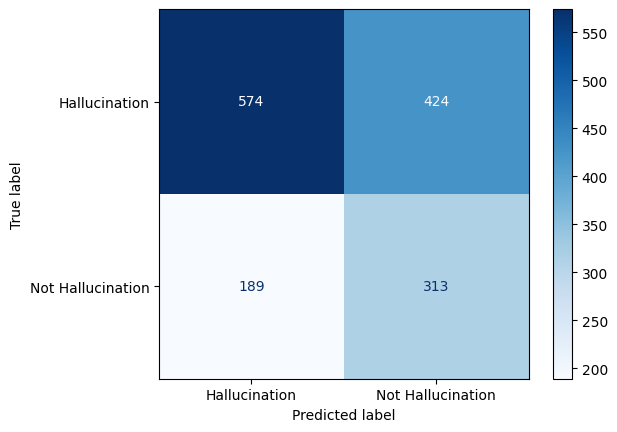

In [63]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def evaluate_predictions(data, label_column="label", predicted_column="predicted_label", text_column="combined_text"):
    """
    Evaluate predictions with a classification report, confusion matrix,
    average text lengths, and precision & recall calculations.
    
    Parameters:
    - data: DataFrame containing the true labels, predicted labels, and text entries.
    - label_column: Column name for true labels.
    - predicted_column: Column name for predicted labels.
    - text_column: Column name for text entries.
    
    Returns:
    - A dictionary containing metrics.
    """
    results = {}

    # Classification report
    print("Classification Report:")
    report = classification_report(data[label_column], data[predicted_column], output_dict=True)
    results["classification_report"] = report
    print(classification_report(data[label_column], data[predicted_column]))

    # Confusion matrix
    print("Confusion Matrix:")
    cm = confusion_matrix(data[label_column], data[predicted_column], labels=["Hallucination", "Not Hallucination"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Hallucination", "Not Hallucination"])
    disp.plot(cmap="Blues")
    results["confusion_matrix"] = cm

    # Average text length
    data["text_length"] = data[text_column].apply(len)
    avg_length_correct = data[data[label_column] == data[predicted_column]]["text_length"].mean()
    avg_length_incorrect = data[data[label_column] != data[predicted_column]]["text_length"].mean()
    results["average_length_correct"] = avg_length_correct
    results["average_length_incorrect"] = avg_length_incorrect
    print(f"Average length of correct predictions: {avg_length_correct:.2f}")
    print(f"Average length of incorrect predictions: {avg_length_incorrect:.2f}")

    # Precision and recall
    precision = report["Hallucination"]["precision"]
    recall = report["Hallucination"]["recall"]
    results["precision"] = precision
    results["recall"] = recall
    print(f"Precision for Hallucination: {precision:.2f}")
    print(f"Recall for Hallucination: {recall:.2f}")

    return results

results = evaluate_predictions(test_data, label_column="label", predicted_column="predicted_label", text_column="combined_text")


Classification Report:
                   precision    recall  f1-score   support

    Hallucination       0.75      0.58      0.65       998
Not Hallucination       0.42      0.62      0.51       502

         accuracy                           0.59      1500
        macro avg       0.59      0.60      0.58      1500
     weighted avg       0.64      0.59      0.60      1500

Confusion Matrix:


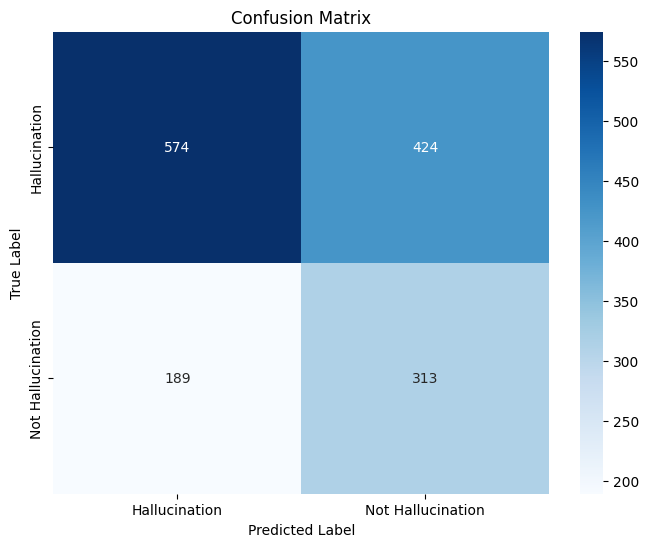

Mean Length Difference (Hallucination): -7.16
Mean Length Difference (Not Hallucination): -4.92
Precision (Hallucination): 0.75
Recall (Hallucination): 0.58


In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def analyze_predictions(data, label_column="label", predicted_column="predicted_label", hyp_column="hyp", tgt_column="tgt"):
    """
    Analyze predictions with classification report, confusion matrix, and mean length difference.
    
    Parameters:
    - data: DataFrame containing the true labels, predicted labels, hyp, and tgt.
    - label_column: Column name for true labels.
    - predicted_column: Column name for predicted labels.
    - hyp_column: Column name for hypothesis text.
    - tgt_column: Column name for target text.
    """
    results = {}

    # Classification Report
    print("Classification Report:")
    report = classification_report(data[label_column], data[predicted_column], output_dict=True)
    print(classification_report(data[label_column], data[predicted_column]))
    results["classification_report"] = report

    # Confusion Matrix with Heatmap
    print("Confusion Matrix:")
    cm = confusion_matrix(data[label_column], data[predicted_column], labels=["Hallucination", "Not Hallucination"])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Hallucination", "Not Hallucination"],
                yticklabels=["Hallucination", "Not Hallucination"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    results["confusion_matrix"] = cm

    # Mean Length Difference
    data["length_diff"] = data[hyp_column].str.len() - data[tgt_column].str.len()
    mean_length_hallucination = data[data[label_column] == "Hallucination"]["length_diff"].mean()
    mean_length_non_hallucination = data[data[label_column] == "Not Hallucination"]["length_diff"].mean()
    results["mean_length_hallucination"] = mean_length_hallucination
    results["mean_length_non_hallucination"] = mean_length_non_hallucination
    print(f"Mean Length Difference (Hallucination): {mean_length_hallucination:.2f}")
    print(f"Mean Length Difference (Not Hallucination): {mean_length_non_hallucination:.2f}")

    # Precision and Recall Focus
    precision_hallucination = report["Hallucination"]["precision"]
    recall_hallucination = report["Hallucination"]["recall"]
    results["precision_hallucination"] = precision_hallucination
    results["recall_hallucination"] = recall_hallucination
    print(f"Precision (Hallucination): {precision_hallucination:.2f}")
    print(f"Recall (Hallucination): {recall_hallucination:.2f}")

    return results

# Example Usage:
# Assuming `test_data` is the DataFrame with predictions
results = analyze_predictions(
    data=test_data,
    label_column="label",
    predicted_column="predicted_label",
    hyp_column="hyp",
    tgt_column="tgt_src"
)
